In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
# import itertools
import matplotlib.pyplot as plt

In [2]:
n_assets = 4
qubits_per_asset = 3
n_qubits = n_assets * qubits_per_asset
max_level = 2 ** qubits_per_asset - 1

# Expected returns
mu = np.array([0.10, 0.20, 0.15, 0.12])

# Covariance matrix
Sigma = np.array([
    [0.005, -0.010, 0.004, -0.002],
    [-0.010, 0.040, -0.002, 0.004],
    [0.004, -0.002, 0.023, 0.002],
    [-0.002, 0.004, 0.002, 0.018]
])


# Convert qubits to fractional weights
def bitstring_to_weights(bitstring, n_assets, qubits_per_asset):
    weights = []
    for i in range(n_assets):
        bits = bitstring[i*qubits_per_asset : (i+1)*qubits_per_asset]
        decimal = sum(2**j * bits[j] for j in range(qubits_per_asset))
        weights.append(decimal / max_level)
    return np.array(weights)

In [3]:
def build_hamiltonian(mu, Sigma, n_assets, qubits_per_asset, penalty_coeff=100):
    coeffs = []
    observables = []
    
    # Build Hamiltonian for return and risk
    for i in range(n_assets):
        for j in range(qubits_per_asset):
            weight = 2**j / max_level
            # Return term (maximize → minimize -return)
            coeffs.append(-mu[i] * weight)
            observables.append(qml.PauliZ(i * qubits_per_asset + j))

    # Risk term
    for i in range(n_assets):
        for j in range(n_assets):
            if i >= j:
                continue
            for k in range(qubits_per_asset):
                for l in range(qubits_per_asset):
                    weight_i = 2**k / max_level
                    weight_j = 2**l / max_level
                    coeffs.append(Sigma[i, j] * weight_i * weight_j)
                    obs = qml.PauliZ(i * qubits_per_asset + k) @ qml.PauliZ(j * qubits_per_asset + l)
                    observables.append(obs)

    # Budget constraint penalty: (sum(weights) - 1)²
    for i in range(n_qubits):
        for j in range(n_qubits):
            weight_i = (2**(i % qubits_per_asset)) / max_level
            weight_j = (2**(j % qubits_per_asset)) / max_level
            coeffs.append(penalty_coeff * weight_i * weight_j)
            observables.append(qml.PauliZ(i) @ qml.PauliZ(j))

    return qml.Hamiltonian(coeffs, observables)

H = build_hamiltonian(mu, Sigma, n_assets, qubits_per_asset)
print(H)

-0.014285714285714285 * Z(0) + -0.02857142857142857 * Z(1) + -0.05714285714285714 * Z(2) + -0.02857142857142857 * Z(3) + -0.05714285714285714 * Z(4) + -0.11428571428571428 * Z(5) + -0.021428571428571425 * Z(6) + -0.04285714285714285 * Z(7) + -0.0857142857142857 * Z(8) + -0.01714285714285714 * Z(9) + -0.03428571428571428 * Z(10) + -0.06857142857142856 * Z(11) + -0.0002040816326530612 * (Z(0) @ Z(3)) + -0.0004081632653061224 * (Z(0) @ Z(4)) + -0.0008163265306122448 * (Z(0) @ Z(5)) + -0.0004081632653061224 * (Z(1) @ Z(3)) + -0.0008163265306122448 * (Z(1) @ Z(4)) + -0.0016326530612244896 * (Z(1) @ Z(5)) + -0.0008163265306122448 * (Z(2) @ Z(3)) + -0.0016326530612244896 * (Z(2) @ Z(4)) + -0.0032653061224489793 * (Z(2) @ Z(5)) + 8.163265306122448e-05 * (Z(0) @ Z(6)) + 0.00016326530612244895 * (Z(0) @ Z(7)) + 0.0003265306122448979 * (Z(0) @ Z(8)) + 0.00016326530612244895 * (Z(1) @ Z(6)) + 0.0003265306122448979 * (Z(1) @ Z(7)) + 0.0006530612244897958 * (Z(1) @ Z(8)) + 0.0003265306122448979 * (Z

In [4]:
dev = qml.device("default.qubit", wires=n_qubits, shots=50)

@qml.qnode(dev)
def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(H)

params = np.random.randn(3, n_qubits, 3, requires_grad=True)
opt = AdamOptimizer(stepsize=0.1)

steps = 25
for i in range(steps):
    params = opt.step(circuit, params)
    if i % 10 == 0:
        print(f"Step {i}, Cost = {circuit(params):.4f}")

Step 0, Cost = 130.9543
Step 10, Cost = 159.0233
Step 20, Cost = 170.3149


In [ ]:
@qml.qnode(dev)
def final_sample():
    qml.templates.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return [qml.sample(qml.PauliZ(i)) for i in range(n_qubits)]

bitstring_raw = (1 - np.array(final_sample())) // 2  # shape: (n_qubits, n_shots)
bitstring = bitstring_raw[:, 0]  # Take first shot (shape: n_qubits,)
weights = bitstring_to_weights(bitstring, n_assets, qubits_per_asset)
weights = weights / np.sum(weights)  # Normalize
print("Binary Sampled Bitstring:", bitstring)

Binary Sampled Bitstring: [0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
Portfolio Allocation:


In [ ]:
# Each asset is encoded with 3 qubits, forming a 3-bit binary number. The decimal value is scaled to [0, 1] and then normalized to sum to 1.
# This section explains how the sampled bitstring maps to fractional portfolio weights.
def explain_bitstring_mapping(bitstring, n_assets, qubits_per_asset):
    max_level = 2 ** qubits_per_asset - 1
    print("Bitstring:", bitstring)
    print(f"{'Asset':<8}{'Bits':<10}{'Decimal':<10}{'Scaled':<12}{'Normalized %'}")
    
    weights = []
    for i in range(n_assets):
        bits = bitstring[i*qubits_per_asset:(i+1)*qubits_per_asset]
        decimal = sum(2**j * bits[j] for j in range(qubits_per_asset))
        scaled = decimal / max_level
        weights.append(scaled)
    
    weights = np.array(weights)
    norm_weights = weights / np.sum(weights)

    for i in range(n_assets):
        bits = ''.join(str(int(b)) for b in bitstring[i*qubits_per_asset:(i+1)*qubits_per_asset])
        print(f"{f'Asset {i+1}':<8}{bits:<10}{int(weights[i]*max_level):<10}{weights[i]:<12.3f}{norm_weights[i]*100:.1f}%")

    return norm_weights

# Example use:
weights = explain_bitstring_mapping(bitstring, n_assets, qubits_per_asset)

Bitstring: [0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
Asset   Bits      Decimal   Scaled      Normalized %
Asset 1 011       6         0.857       50.0%
Asset 2 100       1         0.143       8.3%
Asset 3 000       0         0.000       0.0%
Asset 4 101       5         0.714       41.7%


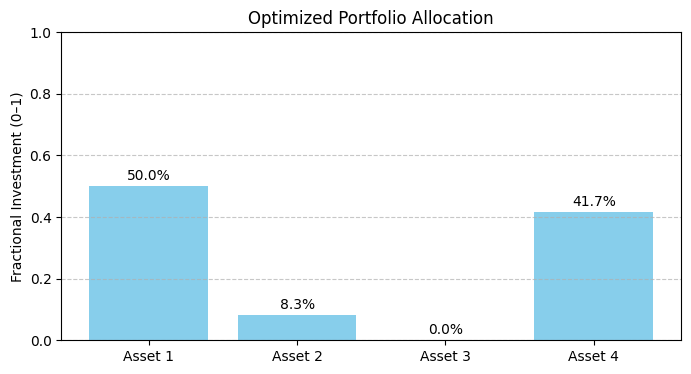

In [ ]:
# Plot bar chart
plt.figure(figsize=(8, 4))

asset_labels = [f"Asset {i+1}" for i in range(n_assets)]
plt.bar(asset_labels, weights, color='skyblue')

for i, v in enumerate(weights):
    plt.text(i, v + 0.02, f"{v*100:.1f}%", ha='center')

plt.title("Optimized Portfolio Allocation")
plt.ylabel("Fractional Investment (0–1)")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

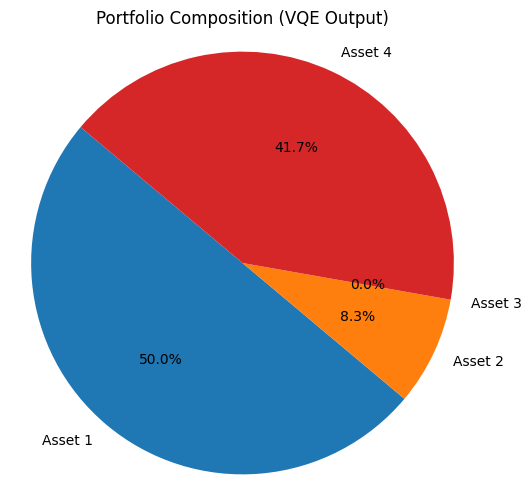

In [ ]:
# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(weights, labels=asset_labels, autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Composition (VQE Output)")
plt.axis('equal')  # Make pie circular
plt.show()